In [38]:
import pyspark
import pandas as pd
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
import pyspark.sql.functions as f

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.optimize import curve_fit
import numpy as np
import math
import datetime
from datetime import timedelta
import seaborn as sns
import warnings

spark = SparkSession.builder.appName("bigdata")\
                    .config("spark.some.config.option", "some-value")\
                    .getOrCreate()

In [39]:
%run data.py
warnings.filterwarnings("ignore")  # ignore warnings

In [40]:
# filter the dataframe, just leave the cases, deaths and ever-hospitalized
nycBorough = fetchData(nyc_his_boro_url)
borough = nycBorough[(nycBorough.type == "cases") | (nycBorough.type == "deaths") | (nycBorough.type == "ever-hospitalized")]
borough["timestamp"] = pd.to_datetime(borough["timestamp"])
borough["timestamp"] = borough["timestamp"].dt.tz_convert("us/eastern")

# change the timestamp to date and rearrange the columns
borough["timestamp"] = borough["timestamp"].astype(np.str_)
borough[["date","time"]] = borough["timestamp"].str.split(" ", expand = True)
borough = borough[["date","type","bronx","brooklyn","manhattan","queens","staten_island","unknown","total"]]
borough["date"] = pd.to_datetime(borough['date'])
#borough.head(5)

# get the latest data for condirmed cases, deaths and hospitalized
update = borough.tail(3)
update.set_index(["type"], inplace = True) 
update

,date,bronx,brooklyn,manhattan,queens,staten_island,unknown,total
type,,,,,,,,
cases,2020-05-11,41746,50079,22771,56899,12733,91,184319
deaths,2020-05-11,3247,4596,2000,4529,721,8,15101
ever-hospitalized,2020-05-11,11075,13084,7151,15468,2140,21,48939


In [41]:
# function for getting start/end date and time range of dataframe
def getStartDate(inputeData):
    firstRow = inputeData.head(1)
    start_date = firstRow.iloc[[0],[0]].values[0][0]
    start_date = pd.to_datetime(str(start_date)).strftime("%Y-%m-%d")
    return start_date

def getLastDate(inputeData):
    lastRow = inputeData.tail(1)
    latest_date = lastRow.iloc[[0],[0]].values[0][0]
    latest_date = pd.to_datetime(str(latest_date)) #.strftime("%Y-%m-%d")
    
    delta = datetime.timedelta(days = 1)
    latest_date = latest_date + delta
    latest_date = pd.to_datetime(str(latest_date)).strftime("%Y-%m-%d")
    return latest_date

def getTimeRange(inputeData):
    print("Update: " + getLastDate(inputeData) + "\t(from " + getStartDate(inputeData) + ")")

In [42]:
# regional all data generalize function
def regionData (regionSourceData, region):
    case = regionSourceData[(regionSourceData.type == "cases")]
    death = regionSourceData[(regionSourceData.type == "deaths")]
    hosp = regionSourceData[(regionSourceData.type == "ever-hospitalized")]
    
    case.rename(columns = {region:"cases"}, inplace = True)
    case.drop_duplicates(subset = "date", keep = "last", inplace = True)
    case.drop(columns = ["type"], inplace = True)
    
    death.rename(columns = {region:"deaths"}, inplace= True)
    death.drop_duplicates(subset = "date", keep = "last", inplace = True)
    death.drop(columns = ["type"], inplace = True)

    hosp.rename(columns = {region:"ever-hospitalized"}, inplace = True)
    hosp.drop_duplicates(subset = "date", keep = "last", inplace = True)
    hosp.drop(columns = ["type"], inplace = True)
    
    mergeHelper = pd.merge(case, hosp, how = "outer", on = ["date"])
    regionAllData = pd.merge(mergeHelper, death, how = "outer", on = ["date"])
    regionAllData = regionAllData.fillna(0)
    regionAllData[["cases", "ever-hospitalized", "deaths"]] \
                    = regionAllData[["cases", "ever-hospitalized", "deaths"]].astype(int)
    return regionAllData

In [43]:
# regional plot generalize function
def regionPlot (regionAllData, region):
    df = regionAllData
    #df["date"] = df["date"].astype(np.str_)
    #df["date"] = pd.to_datetime(df["date"])
    df = df.set_index("date")

    df[["cases","ever-hospitalized","deaths"]].plot.area(stacked = False, cmap = "tab10_r")
    plt.title(region.capitalize() + " COVID-19 Data", fontsize = 20)
    plt.rcParams["figure.figsize"] = (9,7)
    plt.legend(prop = {"size":15})
    plt.show()

# NYC COVID-19 Summary

In [44]:
# Summary data updated date 
getTimeRange(borough)

Update: 2020-05-12	(from 2020-03-12)


In [45]:
# NYC summary 
# rearrange col and row
nycSummary = update.drop(columns = ["date"])
cm = sns.light_palette("#66cccc", as_cmap = True)
df1 = nycSummary.stack()
df2 = df1.unstack(0)
df2.style.background_gradient(cmap = cm)

type,cases,deaths,ever-hospitalized
bronx,41746,3247,11075
brooklyn,50079,4596,13084
manhattan,22771,2000,7151
queens,56899,4529,15468
staten_island,12733,721,2140
unknown,91,8,21
total,184319,15101,48939


In [46]:
# edit my zz for save total number csv and data.




# NYC COVID-19 Summary by Date

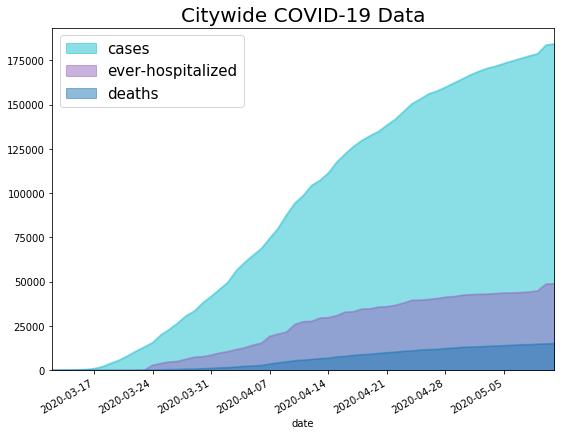

In [47]:
# case, death, haspitalized data for NYC 
nycSourceData = borough[["date","type","total"]] 
nycSourceData = nycSourceData.rename(columns={"total":"Citywide"})
region = "Citywide"
nycAllData = regionData (nycSourceData, region)
regionPlot (nycAllData, region)

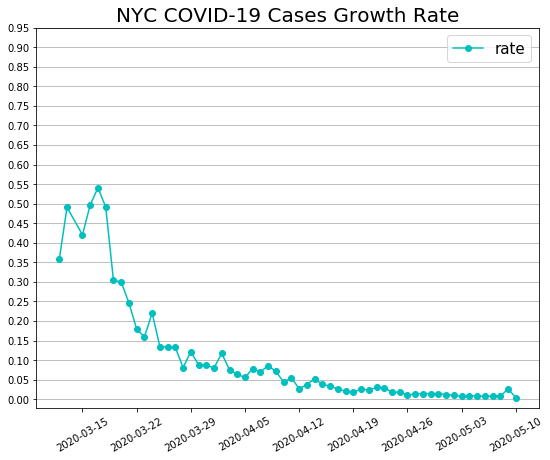

In [48]:
nycChange = nycAllData[["date","cases"]]
nycChange["rate"] = (nycChange["cases"].shift(-1) - nycChange["cases"]) / nycChange["cases"].shift(-1)
#nycChange["rate"] = nycChange["rate"].apply(lambda x: '%.2f%%' % (x*100))

plt.plot("date", "rate", data = nycChange, marker = "o", color = "c")
plt.title("NYC COVID-19 Cases Growth Rate",fontsize = 20)
plt.xticks(rotation = 30)
plt.yticks(np.arange(0, 1, 0.05))
plt.grid(axis = "y",linestyle = "-") 

plt.rcParams["figure.figsize"] = (9,7)
plt.legend(prop = {"size":15})
plt.show()

In [49]:
nycChange.head(3)

,date,cases,rate
0,2020-03-12,88,0.357664
1,2020-03-13,137,0.490706
2,2020-03-15,269,0.420259


# Information for Each Borough

In [50]:
# Cases / Deaths / Hosplitalized Data for Each Borough

# Bronx Data

In [51]:
# case, death, haspitalized data for bronx 
bronxData = borough[["date","type","bronx"]] 
region = "bronx"
bronxAllData = regionData (bronxData, region)
bronxAllData.tail(5)

,date,cases,ever-hospitalized,deaths
55,2020-05-07,40148,10224,3122
56,2020-05-08,40454,10317,3137
57,2020-05-09,40689,10392,3177
58,2020-05-10,41628,11015,3209
59,2020-05-11,41746,11075,3247


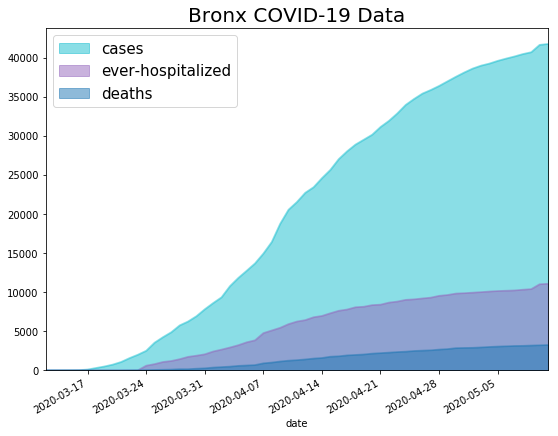

In [52]:
regionPlot (bronxAllData, region)

# Brooklyn Data

In [53]:
# case, death, haspitalized data for brooklyn
brooklynData = borough[["date","type","brooklyn"]] 
region = "brooklyn"
brooklynAllData = regionData (brooklynData, region)
brooklynAllData.tail(5)

,date,cases,ever-hospitalized,deaths
55,2020-05-07,46977,11716,4377
56,2020-05-08,47402,11843,4373
57,2020-05-09,47836,12038,4460
58,2020-05-10,49865,12982,4524
59,2020-05-11,50079,13084,4596


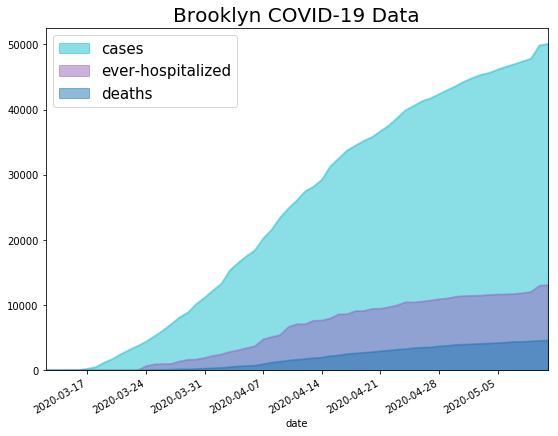

In [54]:
regionPlot (brooklynAllData, region)

# Manhattan Data

In [55]:
# case, death, haspitalized data for manhattan
manhattanData = borough[["date","type","manhattan"]]
region = "manhattan"
manhattanAllData = regionData (manhattanData, region)
manhattanAllData.tail(5)

,date,cases,ever-hospitalized,deaths
55,2020-05-07,21862,5947,1909
56,2020-05-08,22042,5990,1913
57,2020-05-09,22185,6107,1946
58,2020-05-10,22646,7129,1973
59,2020-05-11,22771,7151,2000


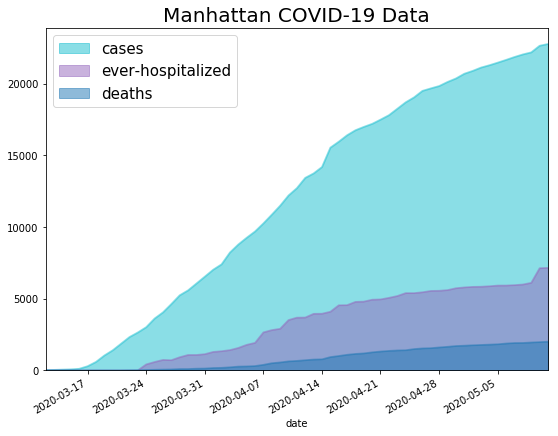

In [56]:
regionPlot (manhattanAllData, region)

# Queens Data

In [57]:
# case, death, haspitalized data for queens
queensData = borough[["date","type","queens"]] 
region = "queens"
queensAllData = regionData (queensData, region)
queensAllData.tail(5)

,date,cases,ever-hospitalized,deaths
55,2020-05-07,54558,14053,4332
56,2020-05-08,54959,14123,4363
57,2020-05-09,55380,14270,4455
58,2020-05-10,56719,15420,4497
59,2020-05-11,56899,15468,4529


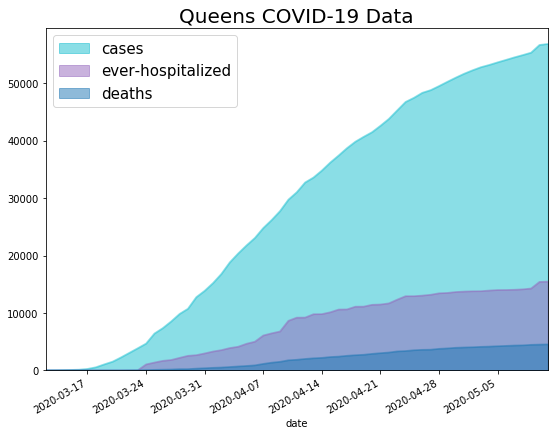

In [58]:
regionPlot (queensAllData, region)

# Staten Island Data

In [59]:
# case, death, haspitalized data for staten_island
staten_islandData = borough[["date","type","staten_island"]] 
region = "staten_island"
staten_islandAllData = regionData (staten_islandData, region)
staten_islandAllData.tail(5)

,date,cases,ever-hospitalized,deaths
55,2020-05-07,12452,1953,681
56,2020-05-08,12535,1963,688
57,2020-05-09,12586,1985,707
58,2020-05-10,12714,2139,717
59,2020-05-11,12733,2140,721


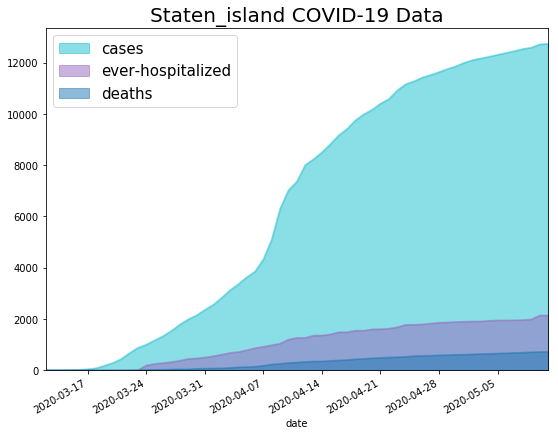

In [60]:
regionPlot (staten_islandAllData, region)

# NYC Cases and Tasted Data

In [61]:
# filter the dataframe, just leave the date and number of tasted
nycTestSource = fetchData(nyc_his_state_url)
nycTest = nycTestSource[["timestamp","nyc_tested","nyc_cases"]]
nycTest = nycTest.fillna(0)
nycTest[["nyc_tested","nyc_cases"]] = nycTest[["nyc_tested","nyc_cases"]].astype(int)
nycTest["timestamp"] = pd.to_datetime(nycTest["timestamp"])
nycTest["timestamp"] = nycTest["timestamp"].dt.tz_convert("us/eastern")
nycTest["timestamp"] = nycTest["timestamp"].astype(np.str_)
nycTest[["date","time"]] = nycTest["timestamp"].str.split(" ", expand = True)
nycTest = nycTest[["date","nyc_tested","nyc_cases"]]
nycTest["date"] = pd.to_datetime(nycTest["date"])
#nycTest = nycTest.set_index("date")

In [62]:
# NYC test data update date
getTimeRange(nycTest)

Update: 2020-05-12	(from 2020-03-15)


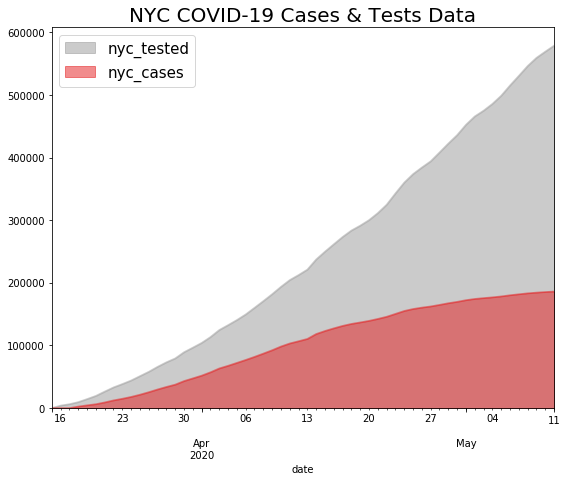

In [63]:
df = nycTest
#df["date"] = pd.to_datetime(df["date"])
df = df.set_index("date")
df[["nyc_tested","nyc_cases"]].plot.area(stacked = False, cmap = "Set1_r")
plt.title("NYC COVID-19 Cases & Tests Data", fontsize = 20)
plt.rcParams["figure.figsize"] = (9,7)
plt.legend(prop = {"size":15})
plt.show()

# Cases by Age Group

In [64]:
# cases by age
casesAge = fetchData(nyc_his_age_url)

# filter the dataframe, just leave the date and number of tasted
ageGroup = casesAge[["timestamp","type","ages_0_17","ages_18_44","ages_45_64","ages_65_74","ages_75_older","unknown"]]
ageGroup[["date","time"]] = ageGroup["timestamp"].str.split("T", expand = True)
ageGroup = ageGroup[["date","type","ages_0_17","ages_18_44","ages_45_64","ages_65_74","ages_75_older","unknown"]]
ageGroup["date"] = pd.to_datetime(ageGroup["date"])

# summary of age group
ageGroupCase = ageGroup[(ageGroup.type == "cases")]
ageGroupCase.drop_duplicates(subset = "date", keep = "last", inplace = True)
ageGroupCaseUpdate = ageGroupCase.tail(1)

ageGroupDeath = ageGroup[(ageGroup.type == "deaths")]
ageGroupDeath.drop_duplicates(subset = "date", keep = "last", inplace = True)
ageGroupDeathUpdate = ageGroupDeath.tail(1)

frames = [ageGroupCaseUpdate, ageGroupDeathUpdate]
ageGroupUpdate = pd.concat(frames).drop(columns=["date"])
ageGroupUpdate.set_index(["type"], inplace = True) 

In [65]:
getTimeRange(ageGroup)

Update: 2020-05-12	(from 2020-03-22)


In [66]:
# cases and deaths for age group
# rearrange col and row
cm = sns.light_palette("#ff7000", as_cmap = True)
df1 = ageGroupUpdate.stack()
df2 = df1.unstack(0)
df2["death_rate_%"] = (df2["deaths"] / df2["cases"] * 100).round(2)
#df2["death_rate_%"] = df2["death_rate_%"].map(lambda x:format(x,'.2%'))
#df2["death_rate"] = df2["death_rate"].apply(lambda x: x.replace('%', '')).astype('float') / 100
df2.style.background_gradient(cmap = cm)

type,cases,deaths,death_rate_%
ages_0_17,4645,10,0.22
ages_18_44,67562,596,0.88
ages_45_64,67364,3383,5.02
ages_65_74,22937,3753,16.36
ages_75_older,21399,7356,34.38
unknown,412,3,0.73


In [67]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, ages_0_17 to unknown
Data columns (total 3 columns):
cases           6 non-null int64
deaths          6 non-null int64
death_rate_%    6 non-null float64
dtypes: float64(1), int64(2)
memory usage: 352.0+ bytes


# NYC COVID-19 Cases Prediction

In [68]:
test = nycAllData[["date","cases"]]
firstDay = getStartDate(test)
lastDay = getLastDate(test)
start = datetime.datetime.strptime(firstDay, "%Y-%m-%d")
end = datetime.datetime.strptime(lastDay, "%Y-%m-%d")

days = len(test)
Time = np.arange(1,days+1)
P = np.array(test["cases"])

In [69]:
# locistic increase model
# t:time t0:initial time P0:initial value K:capacity r:increase rate
# greater r faster to K

fast_r = 0.099
slow_r = 0.109

def logisticIncreaseFunction(t,K,P0,r):
    t0 = 1
    exp_value = np.exp(r*(t-t0))
    return (K*exp_value*P0)/(K+(exp_value - 1)*P0)

def fasterLIF(t,K,P0):
    return logisticIncreaseFunction(t,K,P0,r = fast_r)

def slowerLIF(t,K,P0):
    return logisticIncreaseFunction(t,K,P0,r = slow_r)

In [70]:
def nearFuture(startDate, num):
    delta = datetime.timedelta(days = 1)
    predict = pd.DataFrame(columns = ["date", "cases_fast", "cases_slow"])
    for i in range(2, num+2):
        curr = startDate + delta * (days+i) 
        currDate = curr.strftime("%Y-%m-%d")
        fast = int(fasterLIF(np.array(days+i),poptFast[0],poptFast[1]))
        slow = int(slowerLIF(np.array(days+i),poptSlow[0],poptSlow[1]))
        
        predict = predict.append(pd.DataFrame({"date":[currDate], "cases_fast":[fast], "cases_slow":[slow]}),ignore_index = True) 
    
    return predict[["date", "cases_fast", "cases_slow"]]

In [71]:
getTimeRange(test)

Update: 2020-05-12	(from 2020-03-12)


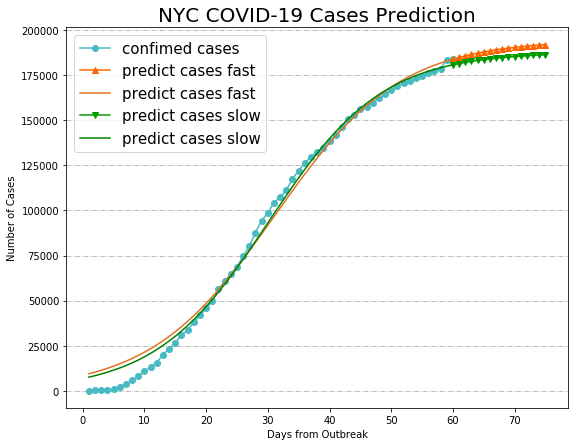

In [72]:
# data fitting: least squares approximation 
# popt: coefficient pcov：covariance matrix
poptFast, pcovFast = curve_fit(fasterLIF, Time, P)
poptSlow, pcovSlow = curve_fit(slowerLIF, Time, P)

# predict cases
predictCasefast = fasterLIF(Time,poptFast[0],poptFast[1])
predictCaseSlow = slowerLIF(Time,poptSlow[0],poptSlow[1])

# near future predict cases
nextDay = np.arange(days, days+16)
nextDay_predictFast = logisticIncreaseFunction(nextDay,poptFast[0],poptFast[1],r = fast_r)
nextDay_predictSlow = logisticIncreaseFunction(nextDay,poptSlow[0],poptSlow[1],r = slow_r)

plot1 = plt.plot(Time, P, color = "#49b9c2", marker = "o", label = "confimed cases")
plot2 = plt.plot(nextDay, nextDay_predictFast, color = "#ff6500", marker = "^", label = "predict cases fast")
plot3 = plt.plot(Time, predictCasefast, color = "#e17223",label = "predict cases fast")
plot4 = plt.plot(nextDay, nextDay_predictSlow, color = "#009900", marker = "v", label = "predict cases slow")
plot5 = plt.plot(Time, predictCaseSlow, color = "#008000",label = "predict cases slow")

plt.xlabel("Days from Outbreak")
plt.ylabel("Number of Cases")
plt.title("NYC COVID-19 Cases Prediction", fontsize = 20)
plt.grid(axis = "y",linestyle = "-.") 
plt.legend(prop = {"size":15})
plt.show()

# NYC COVID-19 Cases Prediction in A Week

In [73]:
pred = nearFuture(start, 7)
pred[["cases_fast","cases_slow"]] = pred[["cases_fast","cases_slow"]].astype(int)
cm = sns.light_palette("#66cccc", as_cmap = True)
pred.style.background_gradient(cmap = cm)

,date,cases_fast,cases_slow
0,2020-05-13,185824,182182
1,2020-05-14,186616,182752
2,2020-05-15,187339,183265
3,2020-05-16,187999,183728
4,2020-05-17,188601,184145
5,2020-05-18,189149,184521
6,2020-05-19,189649,184859


In [74]:
# end